# Load Data

In [1]:
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam

Using TensorFlow backend.


## National Data

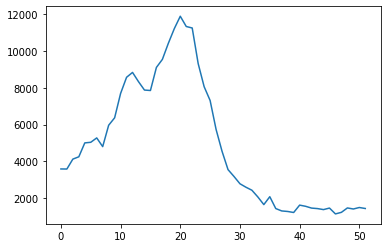

In [2]:
# Load Dataset
ilinet_full = pd.DataFrame(pd.read_csv('ILINet.csv'))
ilinet_full_seasons =ilinet_full[0:782]
data = ilinet_full_seasons['ILITOTAL'].values
#scaler = MinMaxScaler(feature_range=(-1, 1))
#data=scaler.fit_transform(ilinet_full_seasons['ILITOTAL'].values.reshape(-1, 1))

# format data to be seasonal
end_weeks=ilinet_full_seasons.index[ilinet_full_seasons['WEEK'] == 39].tolist()
start_weeks=ilinet_full_seasons.index[ilinet_full_seasons['WEEK'] == 40].tolist()

seasons=[]
for i in range(len(start_weeks)):
    c=start_weeks[i]
    seasons.append(data[c:c+52])
plt.plot(seasons[1])
seasons=np.vstack(seasons)

## State Data 

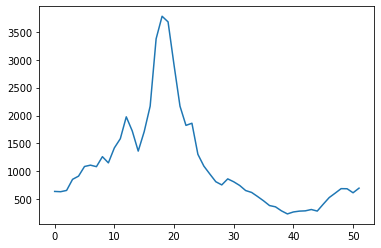

In [3]:
ilinet_full_state = pd.DataFrame(pd.read_csv('ILINet_mod_state.csv'))

#remove missing data
FL=ilinet_full_state.index[ilinet_full_state['REGION'] == 'Florida'].tolist()
ilinet_full_state= ilinet_full_state[~ilinet_full_state.index.isin(FL)]
CM=ilinet_full_state.index[ilinet_full_state['REGION'] == 'Commonwealth of the Northern Mariana Islands'].tolist()
ilinet_full_state= ilinet_full_state[~ilinet_full_state.index.isin(CM)]
#Arrange by state
region_names =ilinet_full_state['REGION'][0:51]#0:51
df = pd.DataFrame(index=range(len(ilinet_full_state)),columns = ilinet_full_state.columns)
c = 0
for region in region_names:
    indices = ilinet_full_state.index[ilinet_full_state['REGION'] == region].tolist()
    state = ilinet_full_state[ilinet_full_state.index.isin(indices)]
    for col in ilinet_full_state.columns:
        df[col][c:c+len(state)] = state[col].values
    c = c+len(state)
df = df[0:25296]

#put in seasons format
df_seasons = pd.DataFrame(columns = df['WEEK'].values[0:52])
week_names = df['WEEK'][0:52]
for week in week_names:
    indices = df.index[df['WEEK'] == week].tolist()
    weeks = df[df.index.isin(indices)]['ILITOTAL'].values[0:445]
    weeks = [float(i) for i in weeks]
    df_seasons[week] = weeks
    
data = df_seasons.values
plt.plot(data[8])

# SIR Model on Full Data

[0.00084983 0.27230623 0.11482441]
2.371501337778094


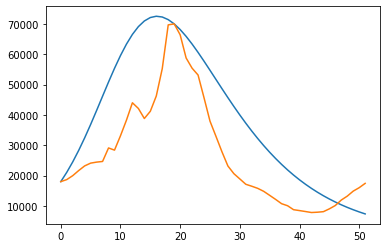

In [4]:
from scipy.integrate import odeint
from scipy import optimize

# The SIR model differential equations.
def sir_model(y, t, params):
    S, I, R = y
    dSdt = -params[1] * S * I / (params[0]*N)
    dIdt = params[1] * S * I / (params[0]*N) - params[2] * I
    dRdt = params[2] * I
    return (dSdt, dIdt, dRdt)

#def balance_model(init,p,t):
    # Initial conditions vector
    #y0 = p[0]*N-1, 1, 0
    #f = lambda y,t: sir_model(y, t, p)
    #ret = odeint(f, y0, t)
    #S, I, R = ret.T
    #a = abs(I-init).tolist()
    #val=a.index(min(a)) 
    #t = np.linspace(0, 52, 52)
    #y0 = S[val], I[val], R[val]
    #return y0,t

def run_model(init, p):
    #t = np.linspace(0, 1000, 50000)
    f = lambda y,t: sir_model(y, t, p)
    #y0,t = balance_model(init, p,t)
    #print(y0)
    y0 = p[0]*N, init, 0
    ret = odeint(f, y0, t)
    S, I, R = ret.T
    return S, I, R,t

def error_fn(real,model):
    error = real-model
    error[np.argmax(real)]=error[np.argmax(real)]*1000
   
    return error

def real_mod_comp(p,real):
    modelS,modelI,modelR,t = run_model(real[0], p)
    err=error_fn(real,modelI)
    if p[0]<0 or p[1]<0 or p[2]<0 or p[0]>1:
        err = err+10**6
    return err

N=300000000#4500000
t = np.linspace(0, 52, 52)
p0=[.5,.7, 1./14]
fn = lambda p: real_mod_comp(p,seasons[-1])
(c,kvg) = optimize.leastsq(fn, p0) 
print(c)
print(c[1]/c[2] )

S,I1,R,t=run_model(seasons[-1][0], c)
plt.plot(I1)
plt.plot(seasons[-1])

# SIR Model on Partial Data

[0.82750844 7.91062451 7.83709314]
[2.14907264e-04 3.71877094e-01 1.42788515e-01]


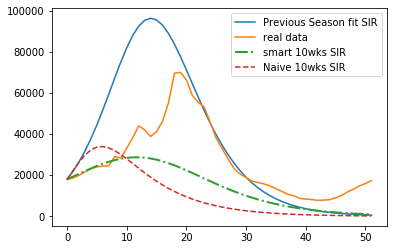

In [5]:
def error_fn2(real,model):
    error = real-model
    error[-1]= error[-1]*1000
    return error
def run_model2(init, p):
    f = lambda y,t: sir_model(y, t, p)
    y0 = p[0]*N, init, 0
    ret = odeint(f, y0, t)
    S, I, R = ret.T
    return I,t
def real_mod_comp2(p,real):
    c=0
    if p[0]<0 or p[1]<0 or p[2]<0:
        c = 10**10
    model,t = run_model2(real[0], p)
    err=error_fn2(real,model)+c
    return err
#linestyles = ['-', '--', '-.', ':']
N=300000000#4500000
p0=[.5,.7, 1./14]
#get initial conditions from last season
fn = lambda p: real_mod_comp(p,seasons[-2])
(c,kvg) = optimize.leastsq(fn, p0) 
p0=c
t = np.linspace(0, 52, 52)
S,I2,R,t=run_model(seasons[-1][0], c)
plt.plot(I2, label="Previous Season fit SIR", linestyle='-')
plt.plot(seasons[-1],label="real data")

numwks=10
t = np.linspace(0, numwks,numwks)
fn = lambda p: real_mod_comp2(p,seasons[-1][0:numwks])
(c,kvg) = optimize.leastsq(fn, p0) 
print(c)

t = np.linspace(0, 52, 52)
S,I3,R,t=run_model(seasons[-1][0], c)
plt.plot(I3, label="smart 10wks SIR", linestyle='-.', linewidth =2)

N=300000000#4500000
p0=[.5,.7, 1./14]
numwks=10
t = np.linspace(0, numwks,numwks)
fn = lambda p: real_mod_comp2(p,seasons[-1][0:numwks])
(c,kvg) = optimize.leastsq(fn, p0) 
print(c)
t = np.linspace(0, 52, 52)
S,I4,R,t=run_model(seasons[-1][0], c)
plt.plot(I4, label="Naive 10wks SIR", linestyle='--')
plt.legend()

# LSTM model

In [6]:
#training and testing on one state, first 9 seasons is AL
scaler = MinMaxScaler(feature_range=(-1, 1))
maxval = seasons.max()
minval = seasons.min()
scaleddata = scaler.fit_transform(seasons[0:-1].reshape(-1, 1))
train_data = torch.FloatTensor(scaleddata).view(-1)
full_data = train_data
train_data = train_data[:-52]
train_window = 52

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data, train_window)

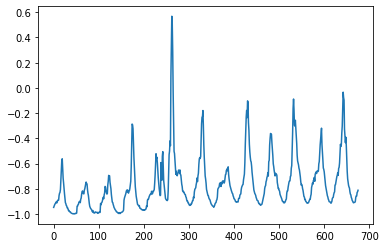

In [7]:
plt.plot(train_data)

In [8]:
#define model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [9]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
epochs = 50
losses=[]
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        losses.append(single_loss)
        single_loss.backward()
        optimizer.step()
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


epoch:   1 loss: 0.00021247
epoch:  26 loss: 0.00006187
epoch:  49 loss: 0.0002207409


In [11]:
losses=[float(i) for i in losses]

41

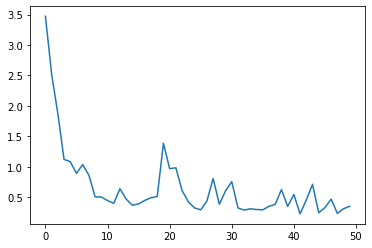

In [12]:
lossperepoch  =[]
sep=int(len(losses)/epochs)
c=0
for i in range(0,len(losses),sep):
    lossperepoch.append(sum(losses[c*sep:c*sep+sep]))
    c=c+1
plt.plot(range(0,epochs),np.log(lossperepoch))
np.argmin(lossperepoch)

In [13]:
fut_pred = 52

test_inputs = full_data[-train_window:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
actual_predictions = np.array(test_inputs[train_window:])

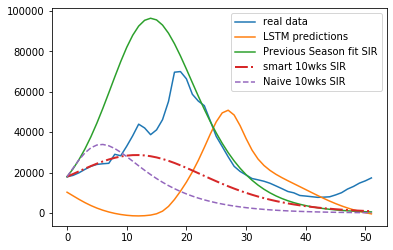

In [14]:
unscaled = scaler.inverse_transform(actual_predictions.reshape(-1, 1))
unscaled
plt.plot(seasons[-1], label='real data')
plt.plot(unscaled, label='LSTM predictions')
#plt.plot(I1, label='SIR best fit on all data')
plt.plot(I2, label="Previous Season fit SIR", linestyle='-')
plt.plot(I3, label="smart 10wks SIR", linestyle='-.', linewidth =2)
plt.plot(I4, label="Naive 10wks SIR", linestyle='--')
plt.legend()
plt.show()

In [15]:
print("Difference in Peak Value:")
print("LSTM Predictions:",abs(unscaled.max() - seasons[-1].max()))
print("Best SIR Prediction:",abs(I2.max() - seasons[-1].max()))
print("")
print("Difference in Peak Week:")
print("LSTM Predictions:",abs(np.argmax(unscaled) - np.argmax(seasons[-1])))
print("Best SIR Prediction:",abs(np.argmax(I2) - np.argmax(seasons[-1])))

Difference in Peak Value:
LSTM Predictions: 19142.4399941042
Best SIR Prediction: 26391.165019990673

Difference in Peak Week:
LSTM Predictions: 8
Best SIR Prediction: 5


# Seq2Seq Model

In [16]:
normalized_seasons=(seasons-seasons.min())/(seasons.max()-seasons.min())

Adapted from
https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Intro.ipynb

In [17]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam


latent_dim = 50 # LSTM hidden units
dropout = .20 

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 1)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
def transform_series_encode(series_array):
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array #- series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    series_array = series_array - np.zeros([len(encode_series_mean),1])#encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [19]:
encoder_input_data = normalized_seasons[0:-2]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = normalized_seasons[-2]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [20]:
#first_n_samples = 20000
batch_size = 2**11
epochs = 100

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = normalized_seasons[0:-2]#get_time_block_series(series_array, date_to_index, 
                                           #train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = normalized_seasons[-2]#get_time_block_series(series_array, date_to_index, 
                                            #train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# lagged target series for teacher forcing
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2);

Instructions for updating:
Use tf.cast instead.
Train on 10 samples, validate on 3 samples
Epoch 1/100
10/10 [==============================] - 1s 65ms/step - loss: 0.2734 - val_loss: 0.2511
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.2516 - val_loss: 0.2301
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 0.2321 - val_loss: 0.2087
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.2059 - val_loss: 0.1884
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1868 - val_loss: 0.1753
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1900 - val_loss: 0.1693
Epoch 7/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1807 - val_loss: 0.1662
Epoch 8/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1727 - val_loss: 0.1638
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1762 - val_loss: 0.1618
Epoch 10/100
10/1

10/10 [==============================] - 0s 4ms/step - loss: 0.0431 - val_loss: 0.0404
Epoch 81/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0435 - val_loss: 0.0408
Epoch 82/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0426 - val_loss: 0.0405
Epoch 83/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0425 - val_loss: 0.0387
Epoch 84/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0430 - val_loss: 0.0364
Epoch 85/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0370 - val_loss: 0.0374
Epoch 86/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0394 - val_loss: 0.0376
Epoch 87/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0394 - val_loss: 0.0348
Epoch 88/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0366 - val_loss: 0.0352
Epoch 89/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0373 - val_loss: 0.0350
Epoch 90/100


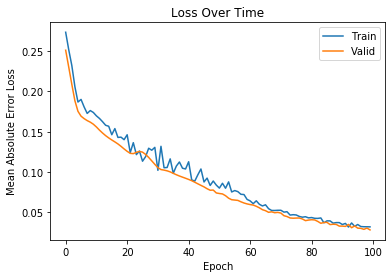

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [22]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

In [23]:
encoder_input_data = normalized_seasons[0:-1]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = normalized_seasons[-1]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

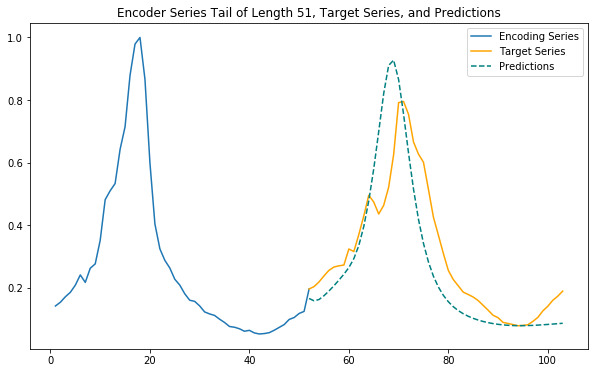

In [24]:
pred_steps=52
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=51):
    encode_series = encoder_input_data[sample_ind:sample_ind+1] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:].reshape(-1,1) 
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))  
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])
    return pred_series
preds= predict_and_plot(encoder_input_data, decoder_target_data, 13)

In [25]:
unscaled2 =preds*(seasons.max()-seasons.min())+seasons.min()

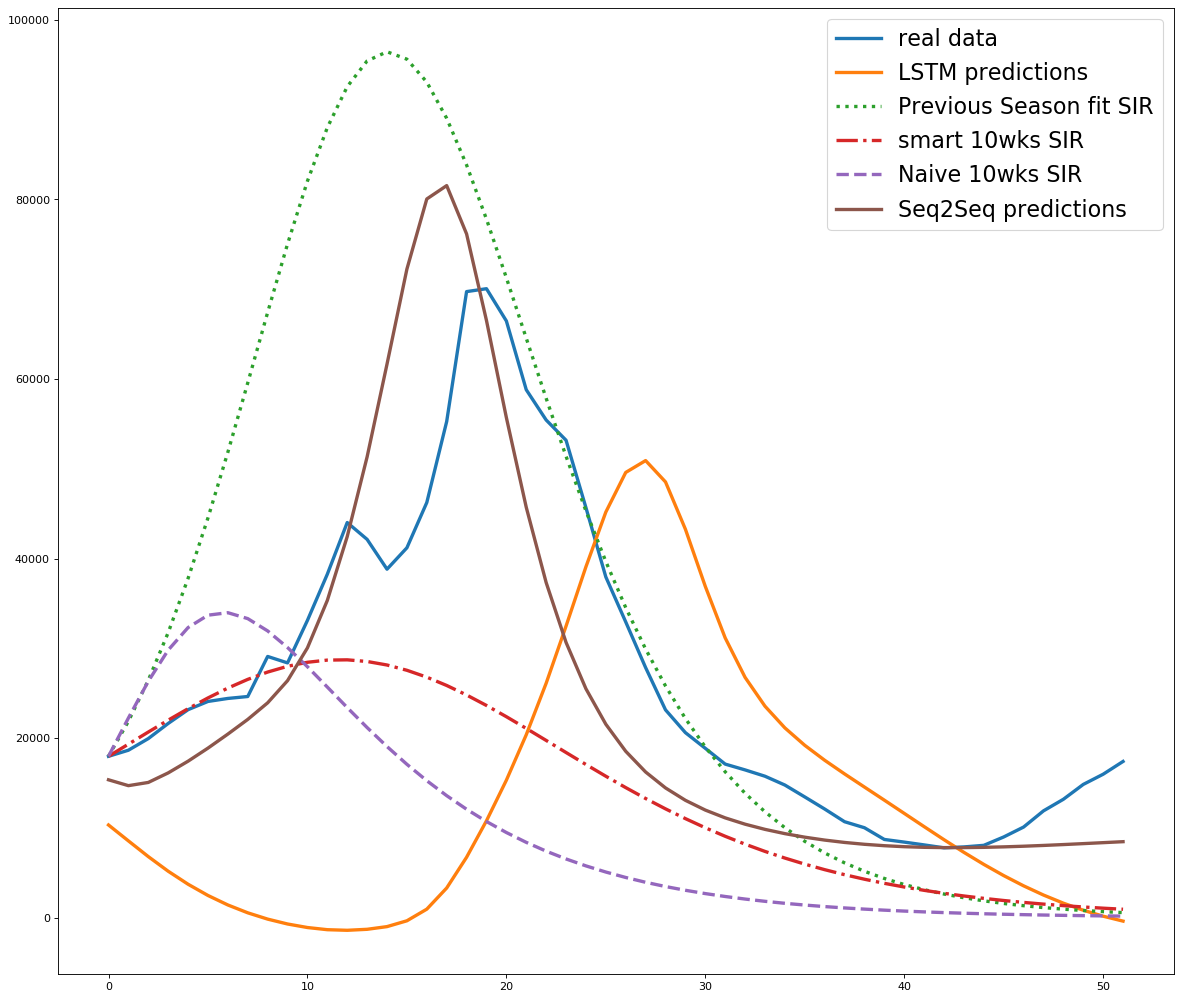

In [35]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(seasons[-1], label='real data', linewidth =3)
plt.plot(unscaled, label='LSTM predictions', linewidth =3)
#plt.plot(I1, label='SIR best fit on all data')
plt.plot(I2, label="Previous Season fit SIR", linestyle=':', linewidth =3)
plt.plot(I3, label="smart 10wks SIR", linestyle='-.', linewidth =3)
plt.plot(I4, label="Naive 10wks SIR", linestyle='--', linewidth =3)
plt.plot(unscaled2, label='Seq2Seq predictions', linestyle='-', linewidth =3)
plt.legend(prop={'size': 20})
plt.show()

In [27]:
print("Difference in Peak Value:")
print("LSTM Predictions:",abs(unscaled.max() - seasons[-1].max()))
print("Best SIR Prediction:",abs(I2.max() - seasons[-1].max()))
print("Seq2Seq Predictions:",abs(unscaled2.max() - seasons[-1].max()))
print("")
print("Difference in Peak Week:")
print("LSTM Predictions:",abs(np.argmax(unscaled) - np.argmax(seasons[-1])))
print("Best SIR Prediction:",abs(np.argmax(I2) - np.argmax(seasons[-1])))
print("Seq2Seq Predictions:",abs(np.argmax(unscaled2) - np.argmax(seasons[-1])))

Difference in Peak Value:
LSTM Predictions: 19142.4399941042
Best SIR Prediction: 26391.165019990673
Seq2Seq Predictions: 11483.228485047817

Difference in Peak Week:
LSTM Predictions: 8
Best SIR Prediction: 5
Seq2Seq Predictions: 2


# Seq2Seq Predictions on current Flu data

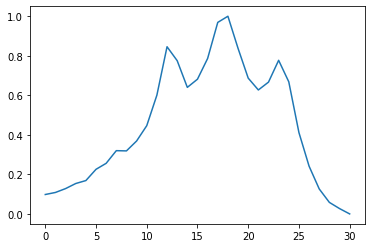

In [65]:
full = pd.DataFrame(pd.read_csv('CLI_ILI_Net.csv'))
full = full[0:31]
ILITotal=full["ILINET"].values
normalized_ili=(ILITotal-ILITotal.min())/(ILITotal.max()-ILITotal.min())
plt.plot(normalized_ili)

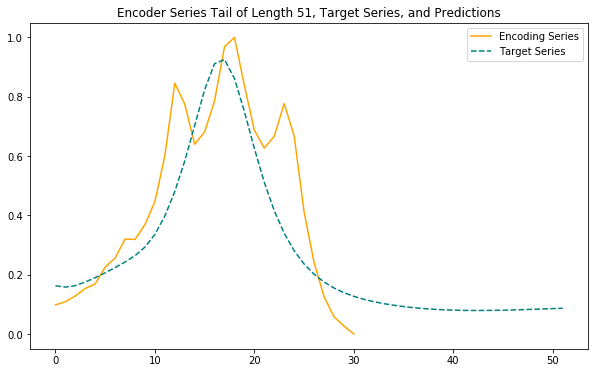

In [66]:
encoder_input_data = normalized_seasons
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = normalized_ili
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
pred_steps=52
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=51):
    encode_series = encoder_input_data[sample_ind:sample_ind+1] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:].reshape(-1,1) 
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))  
    #plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(target_series,color='orange')
    plt.plot(pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])
    return pred_series
preds1= predict_and_plot(encoder_input_data, decoder_target_data, 1)

# Seq2Seq Predictions on current Covid19 data

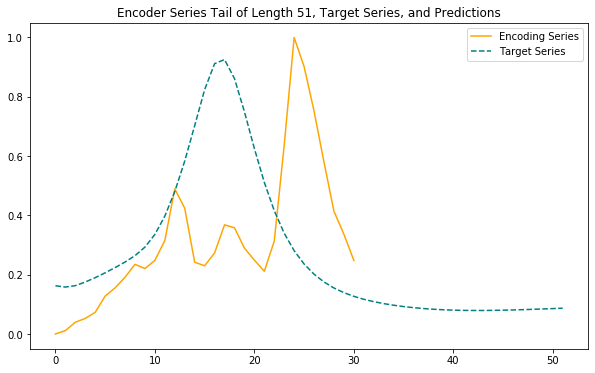

In [47]:
CLITotal=full["CLITotal"].values
normalized_cli=(CLITotal-CLITotal.min())/(CLITotal.max()-CLITotal.min())

encoder_input_data = normalized_seasons
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = normalized_cli
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
pred_steps=52
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=51):
    encode_series = encoder_input_data[sample_ind:sample_ind+1] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:].reshape(-1,1) 
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))  
    #plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(target_series,color='orange')
    plt.plot(pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])
    return pred_series
preds2= predict_and_plot(encoder_input_data, decoder_target_data, 1)

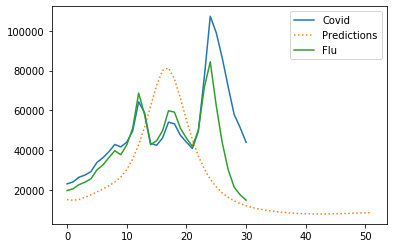

In [58]:
plt.plot(CLITotal, label='Covid')
plt.plot(preds2*(seasons.max()-seasons.min())+seasons.min(), label='Predictions', linestyle = ':')
plt.plot(ILITotal, label='Flu')
plt.legend()

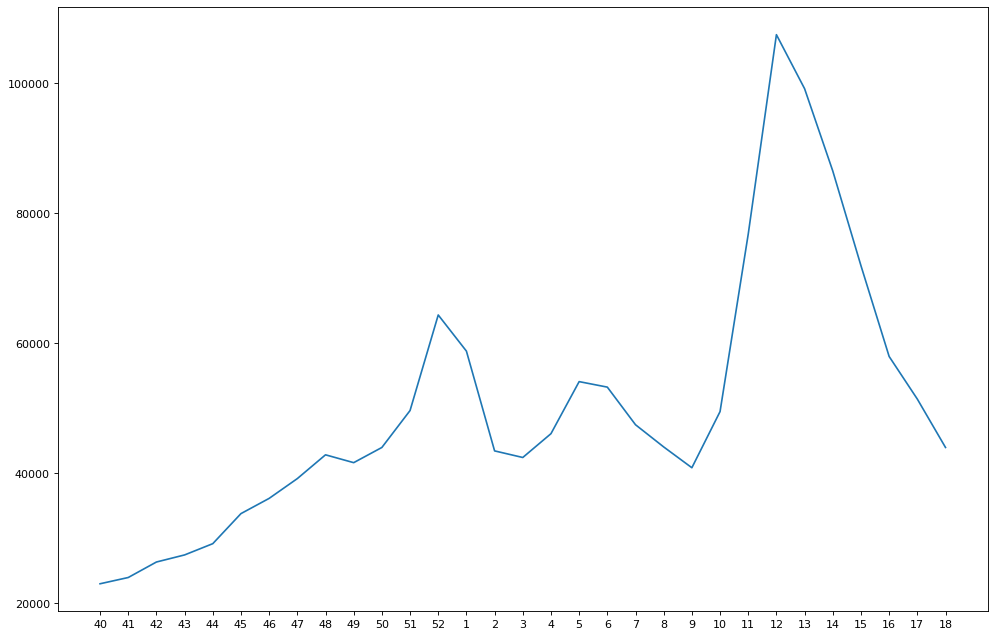

In [64]:
fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
bars = full["Week"].values
y_pos = np.arange(len(bars))
plt.xticks(y_pos, bars)
plt.plot(CLITotal)